In [1]:
import pandas as pd
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import KaplanMeierFitter

# ---------------- Standard Setup ----------------
# local library imports
current_dir = Path.cwd()
train_dir = current_dir.parent / 'src' / 'train'
clinical_dir = current_dir.parent / 'data' / 'clinical'
DATA_DIR = current_dir.parent / 'data'
FEATURES_DIR = current_dir.parent / 'features'

sys.path.append(str(train_dir))
sys.path.append(str(clinical_dir))
from survival import build_parser, getDataTCGA_PDAC, getDataTCGA_All


2025-05-25 21:14:17,238 - INFO - Number of classes = 1 (Survival Only)


ImportError: cannot import name 'getDataTCGA_PDAC' from 'survival' (/mnt/D1/projects/digital-pathology/src/train/survival.py)

In [37]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def plot_survival(time=None, event=None, label="Survival"):
    """
    Plots a Kaplan–Meier survival curve, marks the median (half-life),
    and adds a second title line with Alive/Dead counts & percentages.

    Parameters:
    - time: array-like of durations (follow-up times)
    - event: array-like of event occurrence (1=event happened, 0=censored)
    - label: legend label for the survival curve
    """
    # Fit the KM model
    kmf = KaplanMeierFitter()
    kmf.fit(durations=time, event_observed=event, label=label)

    # Prepare alive/dead stats
    total = len(event)
    dead = int((event == 1).sum())
    alive = total - dead
    pct_dead  = dead  / total * 100
    pct_alive = alive / total * 100
    stats_line = (
        f"Alive = {alive} ({pct_alive:.1f}%), "
        f"Dead = {dead} ({pct_dead:.1f}%), "
        f"Total = {alive + dead}"
    )

    # Plot survival function
    ax = kmf.plot_survival_function(ci_show=True)
    ax.set_xlabel("Time (Days)")
    ax.set_ylabel("Survival Probability")

    # Title with two lines
    ax.set_title(
        "Kaplan–Meier Survival Curve\n"  # first line
        + stats_line                      # second line
    )

    # Compute and annotate median survival time
    median_t = kmf.median_survival_time_
    if median_t is not None:
        ax.hlines(y=0.5, xmin=0, xmax=median_t, linestyles='--', alpha=0.7)
        ax.vlines(x=median_t, ymin=0, ymax=0.5, linestyles='--', alpha=0.7)
        ax.annotate(
            f"Median = {median_t:.2f}",
            xy=(median_t, 0.5),
            xytext=(median_t, 0.6),
            arrowprops=dict(arrowstyle="->", alpha=0.6),
            horizontalalignment='center'
        )

    plt.tight_layout()
    plt.show()


In [10]:
parser = build_parser()

# use parse_known_args if you want to ignore Jupyter flags, or parse_args(argv)
args, _ = parser.parse_known_args([])
args.device = torch.device(f"cuda:{args.cuda_divce}" if torch.cuda.is_available() else "cpu")

# user inputs
args.models = ['ABMIL']
args.losses = 'rank'
args.learning_rate = '1e-4'
args

Namespace(Backbone='UNI', cuda_divce=0, models=['ABMIL'], losses='rank', num_loss=1, loss_weight='1.0', Epoch=100, learning_rate='1e-4', ExternalDatasets=[], repeat=0, device=device(type='cuda', index=0))

In [31]:
Time_NCC     = {}
Event_NCC    = {}

clinical_file = clinical_dir / "clinical.txt"
Clinical = pd.read_csv(clinical_file, sep="\t")
Clinical.set_index('Study_no', inplace=True)

PDAC_path = FEATURES_DIR / "Features_PDAC"
PDAC_Path_Coord = PDAC_path / f"Coord_{args.Backbone}"
Filenames = sorted([p.stem for p in PDAC_Path_Coord.iterdir() if p.suffix == ".pickle"])
Clinical = Clinical.loc[[fn.split('.svs')[0] for fn in Filenames]]
Time_NCC['PDAC'], Event_NCC['PDAC'] = Clinical['PFS_mo'] * (365/12), Clinical['PFS_event_Up220713']

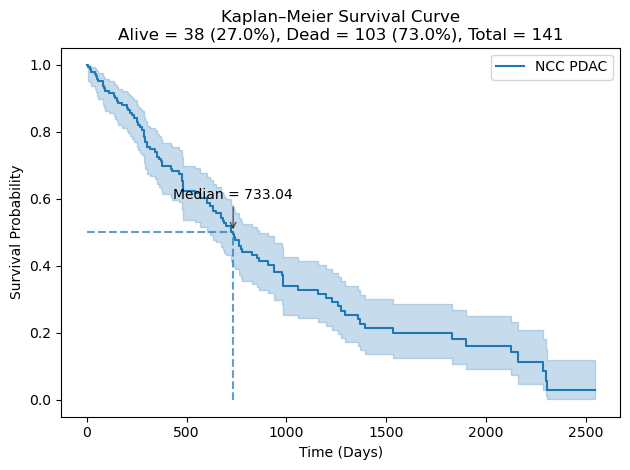

In [38]:
plot_survival(time=Time_NCC['PDAC'], event=Event_NCC['PDAC'], label='NCC PDAC')

In [ ]:
# get TCGA/PDAC data
# prepare empty dicts

Time_TCGA     = {}
Event_TCGA    = {}

_, _, _, Clinical_TCGA = getDataTCGA_PDAC(args)
Time_TCGA['PDAC'] = Clinical_TCGA['Time']
event_mapping = {'Alive': 0, 'Dead': 1}
Event_TCGA['PDAC'] = Clinical_TCGA['Status'].map(event_mapping).astype(int)

/mnt/D1/projects/digital-pathology/src/train/survival.py:144: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Clinical_TCGA = Clinical_TCGA.applymap(lambda x: 0 if x == '\'--' else x)
100%|██████████| 202/202 [02:14<00:00,  1.50it/s]


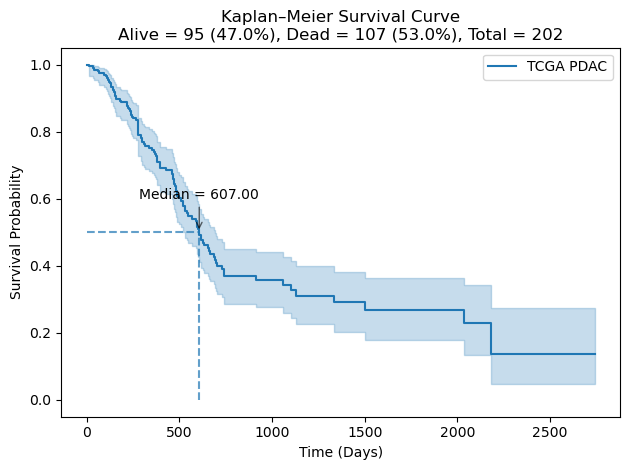

In [39]:
plot_survival(time=Time_TCGA['PDAC'], event=Event_TCGA['PDAC'], label='TCGA PDAC')

In [ ]:
# TCGA data for other cancers

for ct in ['LIHC', 'CHOL', 'LUAD', 'COAD', 'ESCA', 'BRCA']:
    print(f"Processing {ct}...")
    args.ExternalDatasets = [ct]
    _, _, _, times, events = getDataTCGA_All(args, cancer_types=args.ExternalDatasets)
    Time_TCGA[ct]     = times
    Event_TCGA[ct]    = events.map(event_mapping).astype(int)

  4%|▍         | 17/378 [00:13<05:07,  1.18it/s]